In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.transforms import GaussianBlur, ToTensor, ToPILImage, RandomCrop, Compose, Resize, Normalize
from torchvision.datasets import CIFAR10, Flickr8k, CelebA
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001
image_size = 28

# Gaussian Pyramid Constants
num_scales = 3
scale_factor = 2


################# IMPORTANT: This is the variable you change to skip a layer
skipped_scale = -1

# Define the transformations to apply to the CIFAR-10 data
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing the images to 128x128
    transforms.ToTensor(),          # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensors
])



In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
# Set download to True to download the dataset
download = True

# Define the CIFAR-10 training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=download, transform=data_transforms)

# Define the batch size for the dataloader
batch_size = 64

# Define the dataloader to load the CIFAR-10 data in batches during training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


In [13]:
# Define the network architecture with feature pyramid
class CompletionModel(nn.Module):
    def __init__(self, num_scales=3):
        super(CompletionModel, self).__init__()
        self.num_scales = num_scales

        # Define layers for each scale in the feature pyramid
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.channel_reducers = nn.ModuleList()  # 1x1 convolution layers to reduce channels
#         self.downsamplers = nn.ModuleList()
#         self.upsamplers = nn.ModuleList()

        for i in range(num_scales):
            encoder = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
                nn.ReLU()
            )

            decoder = nn.Sequential(
                nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU()
            )

#             if i==skipped_scale:

#                 # Set encoder weights to 0
#                 for layer in encoder:
#                     if isinstance(layer, nn.Conv2d):
#                         layer.weight.data.fill_(0)
#                         layer.bias.data.fill_(0)

# #                 Set decoder weights to 0
#                 for layer in decoder:
#                     if isinstance(layer, nn.ConvTranspose2d):
#                         layer.weight.data.fill_(0)
#                         layer.bias.data.fill_(0)

# #                 Freeze the weights of the encoder
#                 for param in encoder.parameters():
#                     param.requires_grad = False

#                 # Freeze the weights of the decoder
#                 for param in decoder.parameters():
#                     param.requires_grad = False

            self.encoders.append(encoder)
            self.decoders.append(decoder)

            channel_reducer = nn.Conv2d(3, 512, kernel_size=1)  # 1x1 convolution layer to reduce channels
            self.channel_reducers.append(channel_reducer)

        self.upsampler = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)
        self.downsampler = nn.Upsample(scale_factor=1/scale_factor, mode='bilinear', align_corners=False)


    def forward(self, x):
        # Initialize list to store features from each scale
        features = []
        #print(f"x.shape: {x.shape}")

        # Forward pass through each scale in the feature pyramid
        for i in range(self.num_scales):
            encoder_output = self.encoders[i](x)
            features.append(encoder_output)
            #print(f"Feature size at {i}th scale: {features[-1].shape}")
            x = self.downsampler(x)

        # Decode the concatenated features
        shape_feats = list(features[-1].shape)
        shape_feats[1] = 3
        prev_output = None#torch.zeros(shape_feats).to(device)

        for i in range(self.num_scales):

            decoder_output = self.decoders[i](features[self.num_scales - i - 1])
            #print(f"decoder output shape: {decoder_output.shape}")
            if prev_output is None:
                prev_output = self.upsampler(decoder_output)
#             elif i==skipped_scale:# Removing first layer
#                 prev_output = self.upsampler(prev_output)
            else:
                #prev_output = self.channel_reducers[i](prev_output)
                prev_output = self.upsampler(prev_output+decoder_output)
            #print(f"prev_output.shape : {prev_output.shape}")

        #print(decoder_output.shape)
        return decoder_output


In [14]:
downsampler = nn.Upsample(scale_factor=1/scale_factor, mode='bilinear', align_corners=False)

In [15]:
print(device)

cuda:0


In [16]:
model = CompletionModel().to(device)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 15
num_scales = 3

dataloader = train_loader

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, _ in dataloader:
        images = images.to(device)

        occluded_image = images.clone()
        _, _, h, w = occluded_image.shape
        x = torch.randint(0, w // 2, (1,))
        y = torch.randint(0, h // 2, (1,))
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = 0
        # Forward pass and loss calculation
        completion_images = model(occluded_image.to(device))
        loss = criterion(completion_images[:, :, y:y + h // 2, x:x + w // 2], images[:, :, y:y + h // 2, x:x + w // 2])

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Compute the average loss for the epoch
    average_loss = running_loss / len(dataloader)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

# Generate completions for test images
model.eval()
pass

KeyboardInterrupt: 

In [17]:
edge_len = int(128/8)
encoded = model.encoders[0](torch.randn((64, 3, edge_len, edge_len)).to(device))
print(encoded.shape)
model.decoders[0](encoded).shape

torch.Size([64, 512, 1, 1])


torch.Size([64, 3, 16, 16])

In [18]:
# model = CompletionModel().to(device)
# model.load_state_dict(torch.load('ssl_model.pth'))
# # Define the loss function
# criterion = nn.MSELoss()

# # Define the optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [19]:
def unnormalize(img):
    # Define the mean and standard deviation values used for normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Define the un-normalization transform
    unnormalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])

    # Apply un-normalization to the occluded_image
    unnormalized_img = unnormalize(img.cpu().squeeze(0))
    return unnormalized_img

In [29]:
from IPython.display import display, HTML

# # Define test transformations
# test_transform = Compose([
#     ToTensor()
# ])

# Set download to True to download the dataset
download = True

# Define the CIFAR-10 test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=download, transform=data_transforms)

# Define the dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# Load CIFAR-10 test dataset
# test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# # Create test data loader
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    i = 0
    for images, _ in test_dataloader:
        images = images.to(device)

        occluded_image = images.clone()
        _, _, h, w = occluded_image.shape
        x = torch.randint(0, w // 2, (1,))
        y = torch.randint(0, h // 2, (1,))
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = 0

        ########

        # Generate completions using the model
        completions = model(occluded_image.to(device))

        # Convert tensors to PIL images for visualization
        to_pil = ToPILImage()
        true_img = to_pil(unnormalize(images.cpu().squeeze(0)))
        original_img = to_pil(unnormalize(occluded_image.cpu().squeeze(0)))

        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = completions[:, :, y:y + h // 2, x:x + w // 2]
        completed_img = to_pil(unnormalize(occluded_image.cpu().squeeze(0)))

        # Define the HTML style for larger images
        html_style = "<style>img { max-width: 100%; height: auto; }</style>"
        i+=1
        if i==3:
            break

        # Display the original and completed images with larger size
#         display(HTML(html_style))

#         # Display the original and completed images
#         display(original_img)
#         display(completed_img)

Files already downloaded and verified


In [25]:
# model = CompletionModel().to(device)
# model.load_state_dict(torch.load('ssl_model-50.pth'))

<All keys matched successfully>

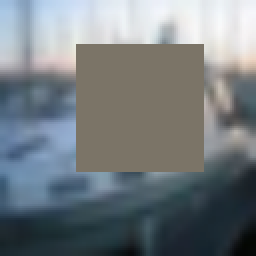

In [30]:
from PIL import Image
original_img.resize((original_img.width * 2,original_img.height * 2),
                                                    Image.NEAREST)


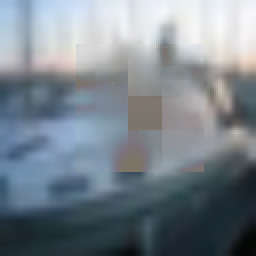

In [31]:
completed_img.resize((completed_img.width * 2,completed_img.height * 2),
                                                    Image.NEAREST)

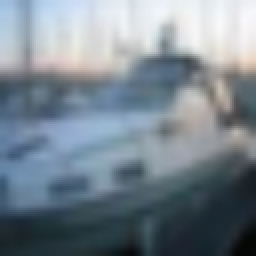

In [32]:
true_img.resize((true_img.width * 2,true_img.height * 2),
                                                    Image.NEAREST)


## Downstream evaluation



In the SSL model trained above, we have multiple encoders. All of these specialize in capturing the information at a specific level.

In [19]:
# torch.save(model.state_dict(), 'ssl_model-15.pth')

In [9]:
test_dataset = datasets.Flowers102(root='./data', split="test", download=download, transform=data_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

train_dataset = datasets.Flowers102(root='./data', split="train", download=download, transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [50]:
skipped_scale=2

### SSL model

In [28]:
model = CompletionModel().to(device)
model.load_state_dict(torch.load('ssl_model.pth'))

input_shape = (256, 128, 128)
# Define the classification model
classification_model = nn.Sequential(
    # Convolutional layers
    nn.AdaptiveAvgPool2d((1, 1)),
#     # Flatten the feature maps
    nn.Flatten(),

#     # Fully connected layers
    nn.Linear(num_scales*512, 256),
    nn.ReLU(),
    nn.Linear(256, 102)  # num_classes is the number of classes for classification
)


for j in range(num_scales):
    if j==skipped_scale:
      encoder = model.encoders[j]
      # Set encoder weights to 0
      for layer in encoder:
          if isinstance(layer, nn.Conv2d):
              layer.weight.data.fill_(0)
              layer.bias.data.fill_(0)
              # Freeze the weights of the encoder
      for param in encoder.parameters():
          param.requires_grad = False


def model_eval(model, classification_model, dataloader):

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)

            encoder_outputs = []
            for j in range(num_scales):
                ####
                encoder_outputs.append(model.encoders[j](images))
            encoder_outputs_stacked = torch.cat(encoder_outputs, dim=1)
            outputs = classification_model(encoder_outputs_stacked)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
#             print(predicted.shape, labels.shape, total, images.shape, outputs.data.shape)
#             print(encoder_outputs_stacked.shape)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam([{'params': classification_model.parameters()}, {'params': model.parameters()}], lr=learning_rate)

num_epochs = 50
classification_model = classification_model.to(device)

log_train_every = 1
log_test_every = 5

trainLoss_ssl, trainAcc_ssl, testAcc_ssl = [], [], []

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        encoder_outputs = []
        for j in range(num_scales):
            encoder_outputs.append(model.encoders[j](inputs))
        encoder_outputs_stacked = torch.cat(encoder_outputs, dim=1)
        outputs = classification_model(encoder_outputs_stacked)

        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # compute training & testing accuracy every couple of iterations
    if (epoch+1) % log_train_every == 0:
        train_accuracy = model_eval(model, classification_model, train_loader)

        # Log the loss
        #writer.add_scalar('Loss/train', loss.cpu().item(), epoch * len(train_loader) + i)

        # Log the training accuracy
        #writer.add_scalar('Accuracy/train', train_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Loss: {running_loss} Accuracy: {train_accuracy}")
        trainLoss_ssl.append(running_loss)
        trainAcc_ssl.append(train_accuracy)

    if (epoch+1) % log_test_every == 0:
        test_accuracy = model_eval(model, classification_model, test_dataloader)

        # Log the test accuracy
        #writer.add_scalar('Accuracy/test', test_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Test Accuracy: {test_accuracy}")
        testAcc_ssl.append(test_accuracy)

# writer.close()
print("Training finished.")

KeyboardInterrupt: 

## Training without SSL

In [52]:
# for i in range(num_scales):
#     model.encoders[i] = nn.Sequential(
#         nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
#         nn.ReLU()
#     )

model = CompletionModel().to(device)

classification_model_nonssl = nn.Sequential(
    # Convolutional layers
    nn.AdaptiveAvgPool2d((1, 1)),
#     # Flatten the feature maps
    nn.Flatten(),

#     # Fully connected layers
    nn.Linear(num_scales*512, 256),
    nn.ReLU(),
    nn.Linear(256, 102)  # num_classes is the number of classes for classification
)

for j in range(num_scales):
    if j==skipped_scale:
      encoder = model.encoders[j]
      # Set encoder weights to 0
      for layer in encoder:
          if isinstance(layer, nn.Conv2d):
              layer.weight.data.fill_(0)
              layer.bias.data.fill_(0)
              # Freeze the weights of the encoder
      for param in encoder.parameters():
          param.requires_grad = False

def model_eval_nonssl(model, classification_model_nonssl, dataloader):

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)

            encoder_outputs = []
            for j in range(num_scales):
                encoder_outputs.append(model.encoders[j](images))
            encoder_outputs_stacked = torch.cat(encoder_outputs, dim=1)
            outputs = classification_model_nonssl(encoder_outputs_stacked)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
#             print(predicted.shape, labels.shape, total, images.shape, outputs.data.shape)
#             print(encoder_outputs_stacked.shape)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


num_epochs = 50
classification_model_nonssl = classification_model_nonssl.to(device)
model = model.to(device)

log_train_every = 1
log_test_every = 5

trainLoss_nonssl, trainAcc_nonssl, testAcc_nonssl = [], [], []

criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam([{'params': classification_model_nonssl.parameters()}, {'params': model.parameters()}], lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        encoder_outputs = []
        for j in range(num_scales):

              encoder_outputs.append(model.encoders[j](inputs))
        encoder_outputs_stacked = torch.cat(encoder_outputs, dim=1)
        outputs = classification_model_nonssl(encoder_outputs_stacked)

        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # compute training & testing accuracy every couple of iterations
    if (epoch+1) % log_train_every == 0:
        train_accuracy = model_eval(model, classification_model_nonssl, train_loader)

        # Log the loss
        #writer.add_scalar('Loss/train', loss.cpu().item(), epoch * len(train_loader) + i)

        # Log the training accuracy
        #writer.add_scalar('Accuracy/train', train_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Loss: {running_loss} Accuracy: {train_accuracy}")
        trainLoss_nonssl.append(running_loss)
        trainAcc_nonssl.append(train_accuracy)

    if (epoch+1) % log_test_every == 0:
        test_accuracy = model_eval(model, classification_model_nonssl, test_dataloader)
        testAcc_nonssl.append(test_accuracy)

        # Log the test accuracy
        #writer.add_scalar('Accuracy/test', test_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Test Accuracy: {test_accuracy}")

# writer.close()
print("Training finished.")

Epoch 1 : Loss: 147.7732982635498 Accuracy: 2.3529411764705883
Epoch 2 : Loss: 138.1171875 Accuracy: 3.5294117647058822
Epoch 3 : Loss: 128.47853469848633 Accuracy: 8.235294117647058
Epoch 4 : Loss: 122.7697377204895 Accuracy: 9.313725490196079
Epoch 5 : Loss: 117.933034658432 Accuracy: 11.666666666666666
Epoch 5 : Test Accuracy: 10.099203122458936
Epoch 6 : Loss: 113.52211666107178 Accuracy: 11.764705882352942
Epoch 7 : Loss: 113.9176242351532 Accuracy: 15.882352941176471
Epoch 8 : Loss: 107.8367030620575 Accuracy: 14.117647058823529
Epoch 9 : Loss: 106.99723958969116 Accuracy: 17.745098039215687
Epoch 10 : Loss: 103.38560152053833 Accuracy: 18.725490196078432
Epoch 10 : Test Accuracy: 12.473572938689218
Epoch 11 : Loss: 100.53792357444763 Accuracy: 20.686274509803923
Epoch 12 : Loss: 97.04127287864685 Accuracy: 23.725490196078432
Epoch 13 : Loss: 93.22912430763245 Accuracy: 24.019607843137255
Epoch 14 : Loss: 91.01071810722351 Accuracy: 28.03921568627451
Epoch 15 : Loss: 87.769409894

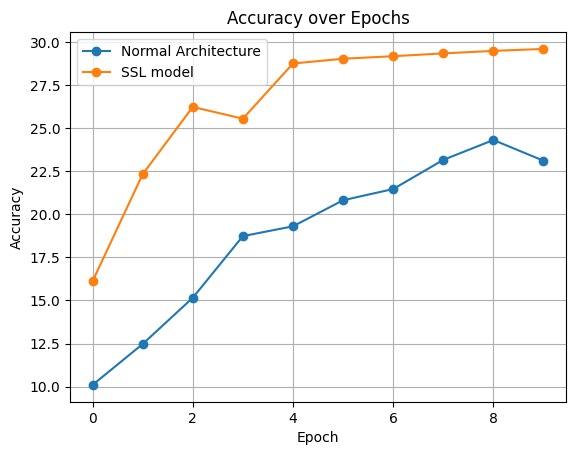

In [53]:
# Skip 3

import matplotlib.pyplot as plt

epochs = range(len(testAcc_nonssl))

plt.plot(epochs, testAcc_nonssl, marker='o', label='Normal Architecture')
plt.plot(epochs, testAcc_ssl, marker='o', label='SSL model')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Final scores going into paper

In [2]:
testAcc_nonssl_3 = [10.099203122458936, 12.473572938689218, 15.156936087168646, 18.73475361847455, 19.303951862091395, 20.816392909416166, 21.46690518783542, 23.158237111725484, 24.312896405919663, 23.10944869084404]
testAcc_ssl_3 = [16.116441697837047, 22.328833956740933, 26.231907627256465, 25.548869734916245, 28.752642706131077, 29.02911042445926, 29.175475687103596, 29.338103756708406, 29.48446901935274, 29.59830866807611]

testAcc_nonssl_2 = [10.213042771182305, 13.368027321515694, 14.994308017563831, 17.84029923564807, 20.637502032850872, 22.14994308017564, 23.190762725646447, 21.23922589038868, 23.499756057895592, 23.35339079525126]
testAcc_ssl_2 = [17.043421694584485, 24.134005529354365, 27.419092535371604, 28.63880305740771, 29.22426410798504, 29.289315335826963, 29.289315335826963, 29.208001301024556, 29.01284761749878, 29.159212880143112]

testAcc_nonssl_1 = [6.944218572125549, 12.213368027321515, 15.173198894129127, 20.01951536835258, 20.718816067653275, 21.678321678321677, 22.458936412424784, 22.068629045373232, 24.15026833631485, 25.207350788746137]
testAcc_ssl_1 = [6.96048137908603, 8.228980322003578, 14.441372580907464, 17.31988941291267, 20.637502032850872, 21.206700276467718, 22.63782728899008, 22.46690518783542, 23.068629045373232, 23.914295007318263]

testAcc_nonssl_0 = [11.286388030574077, 16.083916083916083, 16.376646609204748, 20.14961782403643, 22.05236623841275, 23.22328833956741, 23.890063424947147, 23.402179216132705, 23.141974304765004, 24.247845178077736]
testAcc_ssl_0 = [17.027158887624005, 23.727435355342333, 26.345747275979836, 28.362335339079525, 28.362335339079525, 28.459912180842412, 28.476174987802896, 28.476174987802896, 28.752642706131077, 28.557489022605303]


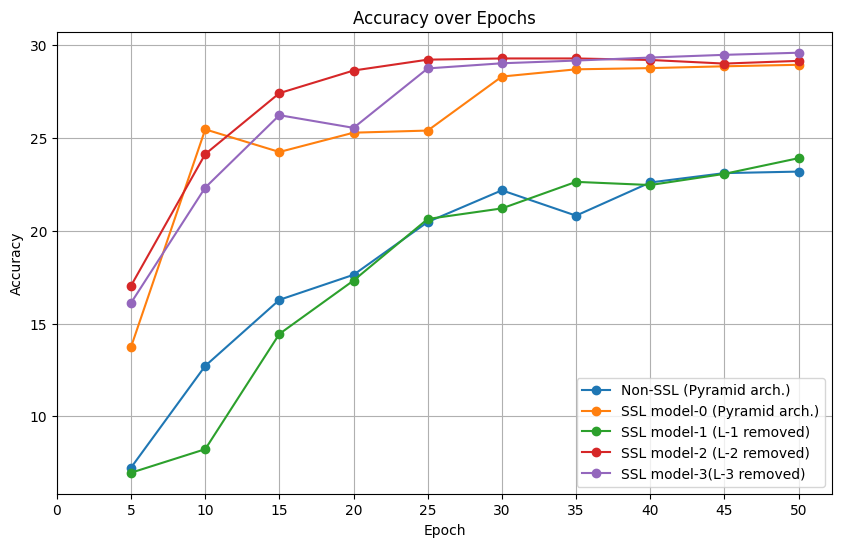

<Figure size 640x480 with 0 Axes>

In [31]:
# Adjusting epochs to match the desired x-axis range (1 to 50)
adjusted_epochs = [i * 5 for i in range(1, 11)]  # 1, 5, 10, 15, ..., 50

# Plotting the data
plt.figure(figsize=(10, 6))

plt.plot(adjusted_epochs, testAcc_nonssl_0, marker='o', label='Non-SSL (Pyramid arch.)')
plt.plot(adjusted_epochs, testAcc_ssl_0, marker='o', label='SSL model-0 (Pyramid arch.)')
# plt.plot(adjusted_epochs, testAcc_nonssl, marker='o', label='Normal Architecture')
plt.plot(adjusted_epochs, testAcc_ssl_1, marker='o', label='SSL model-1 (L-1 removed)')

# # plt.plot(adjusted_epochs, testAcc_nonssl, marker='o', label='Normal Architecture')
plt.plot(adjusted_epochs, testAcc_ssl_2, marker='o', label='SSL model-2 (L-2 removed)')

# # plt.plot(adjusted_epochs, testAcc_nonssl, marker='o', label='Normal Architecture')
plt.plot(adjusted_epochs, testAcc_ssl_3, marker='o', label='SSL model-3(L-3 removed)')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.xticks(range(0, 51, 5))  # Setting x-axis ticks to be from 0 to 50 with step of 5
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('classification-accuracy.png')

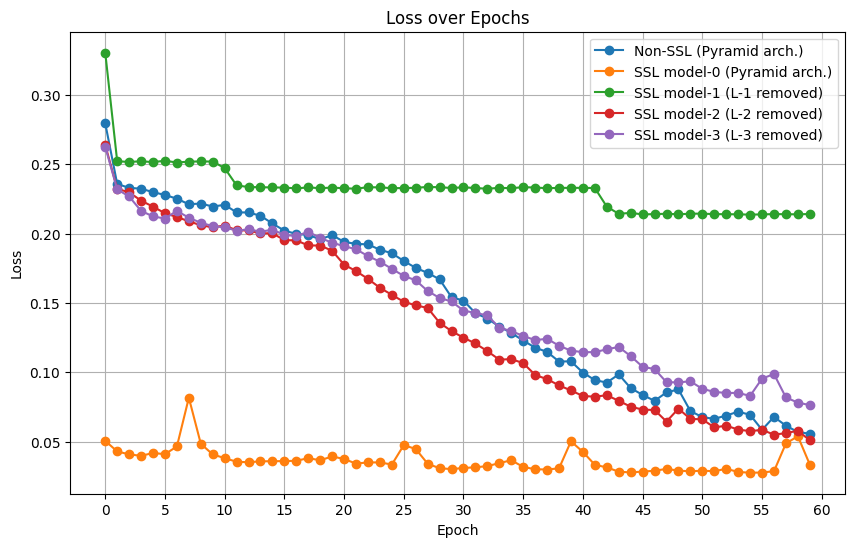

<Figure size 640x480 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt


# Adjusting epochs to match the desired x-axis range (1 to 50)
# adjusted_epochs = [i * 5 for i in range(1, 11)]  # 1, 5, 10, 15, ..., 50

epochs = range(len(loss_ssl_0))

# Plotting the data
plt.figure(figsize=(10, 6))

plt.plot(epochs, loss_non_ssl_0, marker='o', label='Non-SSL (Pyramid arch.)')
plt.plot(epochs, loss_ssl_0, marker='o', label='SSL model-0 (Pyramid arch.)')
plt.plot(epochs, loss_ssl_1, marker='o', label='SSL model-1 (L-1 removed)')
plt.plot(epochs, loss_ssl_2, marker='o', label='SSL model-2 (L-2 removed)')
plt.plot(epochs, loss_ssl_3, marker='o', label='SSL model-3 (L-3 removed)')



# Add other plots for SSL model-1, SSL model-2, SSL model-3...

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.xticks(range(0, 61, 5))  # Setting x-axis ticks to be from 0 to 50 with step of 5
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('segmentation-loss.png')

## with 50 model weights

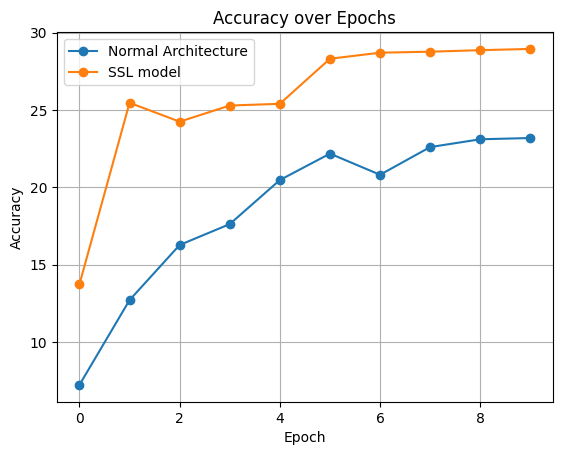

In [34]:
# Skip 0

import matplotlib.pyplot as plt

epochs = range(len(testAcc_nonssl))

plt.plot(epochs, testAcc_nonssl, marker='o', label='Normal Architecture')
plt.plot(epochs, testAcc_ssl, marker='o', label='SSL model')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

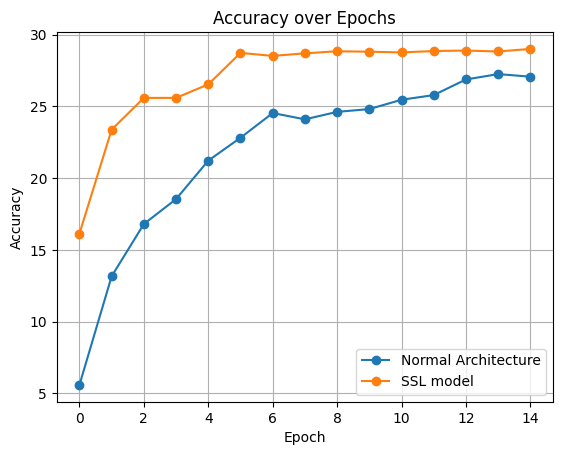

In [24]:
# Skip 0

import matplotlib.pyplot as plt

epochs = range(len(testAcc_nonssl))

plt.plot(epochs, testAcc_nonssl, marker='o', label='Normal Architecture')
plt.plot(epochs, testAcc_ssl, marker='o', label='SSL model')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

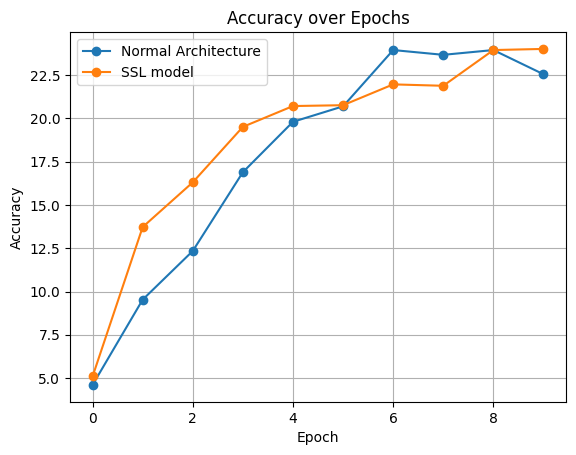

In [17]:
# Skip 1
import matplotlib.pyplot as plt

epochs = range(len(testAcc_nonssl))

plt.plot(epochs, testAcc_nonssl, marker='o', label='Normal Architecture')
plt.plot(epochs, testAcc_ssl, marker='o', label='SSL model')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

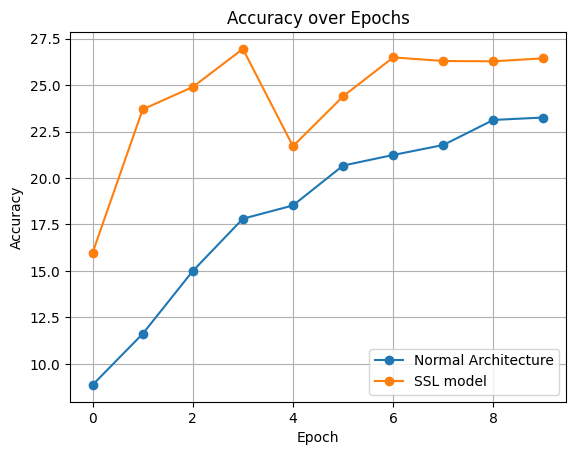

In [23]:
# Skip 2
import matplotlib.pyplot as plt

epochs = range(len(testAcc_nonssl))

plt.plot(epochs, testAcc_nonssl, marker='o', label='Normal Architecture')
plt.plot(epochs, testAcc_ssl, marker='o', label='SSL model')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

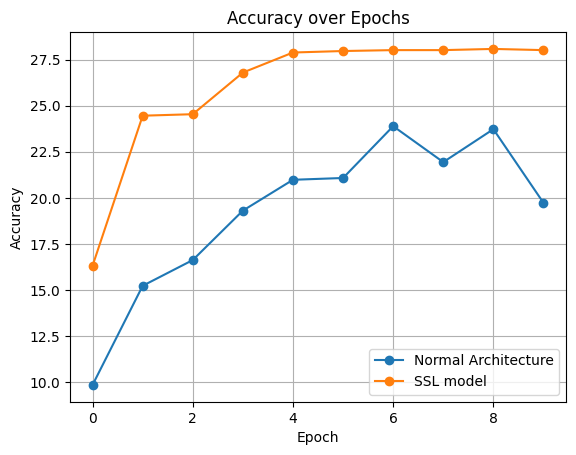

In [29]:
# skip 3
import matplotlib.pyplot as plt

epochs = range(len(testAcc_nonssl))

plt.plot(epochs, testAcc_nonssl, marker='o', label='Normal Architecture')
plt.plot(epochs, testAcc_ssl, marker='o', label='SSL model')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
estAcc_nonssl_0 = [7.236949097414214, 12.717515043096439, 16.27906976744186, 17.628882745161814, 20.474873963246058, 22.182468694096602, 20.816392909416166, 22.605301675069118, 23.10944869084404, 23.190762725646447]
testAcc_ssl_0 = [13.742071881606766, 25.467555700113838, 24.247845178077736, 25.288664823548544, 25.402504472271914, 28.31354691819808, 28.703854285249633, 28.76890551309156, 28.866482354854448, 28.947796389656855]

testAcc_nonssl_1 = [4.60237436981623, 9.530004878842089, 12.343470483005367, 16.897056431940154, 19.80809887786632, 20.702553260692795, 23.95511465278907, 23.67864693446089, 23.95511465278907, 22.556513254187674]
testAcc_ssl_1 = [5.090258578630672, 13.725809074646284, 16.311595381362824, 19.515368352577656, 20.718816067653275, 20.767604488534722, 21.971052203610345, 21.889738168807938, 23.95511465278907, 24.020165880630998]

testAcc_nonssl_2 = [8.863229793462352, 11.611644169783705, 14.994308017563831, 17.80777362172711, 18.52333712798829, 20.670027646771832, 21.23922589038868, 21.775898520084567, 23.12571149780452, 23.25581395348837]
testAcc_ssl_2 = [15.970076435192714, 23.69490974142137, 24.898357456496992, 26.947471133517645, 21.71084729224264, 24.39421044072207, 26.492112538624166, 26.29695885509839, 26.28069604813791, 26.443324117742723]

testAcc_nonssl_3 = [9.838998211091234, 15.221987315010571, 16.62058871361197, 19.303951862091395, 20.97902097902098, 21.076597820783867, 23.890063424947147, 21.93852658968938, 23.727435355342333, 19.726784843063914]
testAcc_ssl_3 = [16.311595381362824, 24.459261668563993, 24.5405757033664, 26.80110587087331, 27.890713937225566, 27.972027972027973, 28.020816392909417, 28.020816392909417, 28.08586762075134, 28.020816392909417]


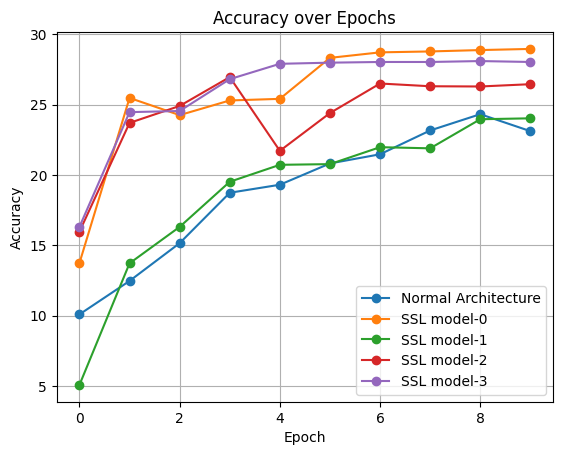

In [63]:
# Skip 0

import matplotlib.pyplot as plt

epochs = range(len(testAcc_nonssl))

plt.plot(epochs, testAcc_nonssl, marker='o', label='Normal Architecture')
plt.plot(epochs, testAcc_ssl_0, marker='o', label='SSL model-0')

# plt.plot(epochs, testAcc_nonssl, marker='o', label='Normal Architecture')
plt.plot(epochs, testAcc_ssl_1, marker='o', label='SSL model-1')

# # plt.plot(epochs, testAcc_nonssl, marker='o', label='Normal Architecture')
plt.plot(epochs, testAcc_ssl_2, marker='o', label='SSL model-2')

# # plt.plot(epochs, testAcc_nonssl, marker='o', label='Normal Architecture')
plt.plot(epochs, testAcc_ssl_3, marker='o', label='SSL model-3')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Segmentation with SSL Based model

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50
from sklearn.metrics import jaccard_score
import numpy as np
from sklearn.metrics import accuracy_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 60
batch_size = 4
learning_rate = 0.005

In [14]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# VOC2012 Segmentation dataset
train_dataset = VOCSegmentation(root='./data',
                                year='2012',
                                image_set='train',
                                download=True,
                                transform=transform,
                                target_transform=transform)

test_dataset = VOCSegmentation(root='./data',
                               year='2012',
                               image_set='val',
                               download=True,
                               transform=transform,
                               target_transform=transform)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [30]:
model = CompletionModel().to(device)
model.load_state_dict(torch.load('ssl_model-50.pth'))

<All keys matched successfully>

In [31]:
skipped_scale = 1

In [32]:
def evaluate_model(model_, test_loader, device):
    model_.eval()
    total_iou = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = torch.as_tensor(np.array(targets), dtype=torch.long).squeeze(1).to(device)
            outputs = model_(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu().numpy()

            for i in range(len(targets)):
                total_iou += jaccard_score(targets[i].flatten().cpu(), predicted[i].flatten(), average='macro')
                total_accuracy += accuracy_score(targets[i].cpu().flatten(), predicted[i].flatten())

    avg_iou_ = total_iou / len(test_loader.dataset)
    avg_accuracy_ = total_accuracy / len(test_loader.dataset)
    return avg_iou_, avg_accuracy_


In [18]:
# Data loader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [33]:
log_test_every = 5
iou_scores_ssl, pixel_accuracies_ssl = [], []


for i in range(num_scales):
    if (i==skipped_scale):
      encoder = model.encoders[i]
      # Set encoder weights to 0
      for layer in encoder:
          if isinstance(layer, nn.Conv2d):
              layer.weight.data.fill_(0)
              layer.bias.data.fill_(0)
              # Freeze the weights of the encoder
      for param in encoder.parameters():
          param.requires_grad = False

num_classes = 21  # Example: Number of classes in your segmentation dataset
# model = SegmentationModel(model.encoders[1], 3).to(device)
###########

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

average_loss_per_epoch_ssl = []


for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_batches = 0
    

    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = torch.as_tensor(np.array(targets), dtype=torch.long).squeeze(1).to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, targets.long())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1
        
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / num_batches
    average_loss_per_epoch_ssl.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    ##########

    if (epoch + 1) % log_test_every == 0:
        avg_iou, avg_accuracy = evaluate_model(model, test_loader, device)
        iou_scores_ssl.append(avg_iou)
        pixel_accuracies_ssl.append(avg_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}] Test IoU: {avg_iou:.4f}, Pixel Accuracy: {avg_accuracy:.4f}")


Epoch [1/60], Step [100/366], Loss: 0.1786
Epoch [1/60], Step [200/366], Loss: 0.2941
Epoch [1/60], Step [300/366], Loss: 0.1374
Epoch [1/60], Loss: 0.2657
Epoch [2/60], Step [100/366], Loss: 0.1481
Epoch [2/60], Step [200/366], Loss: 0.1749
Epoch [2/60], Step [300/366], Loss: 0.2894
Epoch [2/60], Loss: 0.2322
Epoch [3/60], Step [100/366], Loss: 0.1628
Epoch [3/60], Step [200/366], Loss: 0.3259
Epoch [3/60], Step [300/366], Loss: 0.1114
Epoch [3/60], Loss: 0.2167
Epoch [4/60], Step [100/366], Loss: 0.2182
Epoch [4/60], Step [200/366], Loss: 0.2111
Epoch [4/60], Step [300/366], Loss: 0.1498
Epoch [4/60], Loss: 0.2161
Epoch [5/60], Step [100/366], Loss: 0.1948
Epoch [5/60], Step [200/366], Loss: 0.1343
Epoch [5/60], Step [300/366], Loss: 0.2611
Epoch [5/60], Loss: 0.2163
Epoch [5/60] Test IoU: 0.4724, Pixel Accuracy: 0.9447
Epoch [6/60], Step [100/366], Loss: 0.2239
Epoch [6/60], Step [200/366], Loss: 0.1474
Epoch [6/60], Step [300/366], Loss: 0.1387
Epoch [6/60], Loss: 0.2155
Epoch [7/6

In [26]:
loss_ssl_3 = [0.2626892598396768, 0.2319808447621559, 0.22682813109188785, 0.2164496147771025, 0.2124301387109066, 0.21093631395306744, 0.2164490087761905, 0.2114848095129748, 0.20785994098974708, 0.20545038650107514, 0.20458798930863215, 0.20211387389018887, 0.20317612855079395, 0.20139003880932682, 0.2028634646103356, 0.19913439580895861, 0.1982664806269557, 0.20135264583135562, 0.19693983636307913, 0.19345733586474845, 0.19101121978925878, 0.18873160662221128, 0.18385663091159257, 0.17979088338102148, 0.17459788039082386, 0.16949514991761558, 0.16635128572746052, 0.15862883900195524, 0.1535893429905339, 0.15106039207245484, 0.14446141521950237, 0.1427886761175316, 0.1410511530874694, 0.13210594566549108, 0.1296794884761826, 0.126201016808061, 0.12318894429936435, 0.12414292965715375, 0.11913274156306285, 0.1155786606498429, 0.11449370245179517, 0.1145006668311162, 0.11655585632705298, 0.11826352739472533, 0.11161854567993534, 0.10392617205249481, 0.10228390415590968, 0.09279001904193496, 0.09269672770643494, 0.09345273353932985, 0.08801739524459579, 0.08581009274094156, 0.08504542049346238, 0.0850950516149646, 0.0829097822746211, 0.09541501452932592, 0.09869836917136862, 0.08179739980240826, 0.07807376166510452, 0.0762940580330667]
loss_ssl_1 = [0.33057627900213493, 0.25221356324077954, 0.25179531636948144, 0.2522071354254022, 0.2516667326209975, 0.2526070484331722, 0.2513436917928073, 0.2520019564309407, 0.25210558232225355, 0.25205142918180246, 0.24733722995702034, 0.23481448493450066, 0.23365162724191374, 0.23351853845712264, 0.2333493445048241, 0.23324942142992725, 0.2326886707031336, 0.233366460707344, 0.23282835123643197, 0.2332583444569606, 0.2327511687992049, 0.2324453661513459, 0.23354471743595404, 0.23337730071176596, 0.2328621320060042, 0.23289869579135394, 0.23309967717756339, 0.23371441926949663, 0.23350266831331565, 0.23297970249353211, 0.2334380605425991, 0.2329339163347346, 0.23242510492847265, 0.2330791925797697, 0.23281971261393827, 0.23353606668082091, 0.23329467554398572, 0.23280670182382474, 0.23304604079391136, 0.23304771039573874, 0.23307006419356405, 0.23293448675199935, 0.21951108906275588, 0.21431592978089234, 0.2150203957950157, 0.21388412961135797, 0.21412647450393665, 0.21435819148935906, 0.21399680138285695, 0.21440642489924458, 0.21446531607967909, 0.2140898518671429, 0.2140596752853993, 0.2139335151334278, 0.21375061050464547, 0.21389773003553433, 0.21412669097790954, 0.21403647474741025, 0.2139384200379171, 0.2142161619060678]
loss_ssl_0 =  [0.050464373967442355, 0.0428543417317579, 0.04072456531318241, 0.03967533880447755, 0.04172631903281791, 0.040871114220694116, 0.04642533389800559, 0.08159102515261518, 0.04842826546439545, 0.04065926108621264, 0.03802795109435753, 0.03538796714064284, 0.03504279219224805, 0.035714699812945935, 0.03577434964213378, 0.035889985505491495, 0.036100280532216436, 0.03799863355590509, 0.03646957375557045, 0.039238509541387606, 0.03738555303250587, 0.0340660706091204, 0.03493760749086982, 0.03490788283722241, 0.03338975393432167, 0.04741700220842912, 0.04461612994400937, 0.03398177062563313, 0.030696519912612404, 0.030124735641878484, 0.03089569494779644, 0.031424837278538065, 0.03222497456701971, 0.034424670773451446, 0.03649377773510791, 0.03166312056395118, 0.029998638687523012, 0.029808927245967374, 0.030632376398565503, 0.0501589063208937, 0.04250659798958995, 0.03319502558528644, 0.03133380558860839, 0.028242400483497992, 0.027697971075406818, 0.028320484133081032, 0.028896138016032715, 0.03025252249122399, 0.029001057793035127, 0.02850543818044695, 0.02897131581704229, 0.028562846942168603, 0.03031638066431945, 0.02804073854095094, 0.027483978308737278, 0.027640108614549286, 0.028547021410239688, 0.04862243614205327, 0.05380823364471152, 0.03340059304559003]
loss_ssl_2 = [0.26398363974087874, 0.23233535653743587, 0.22984887893652656, 0.22381137938447337, 0.21948083693701062, 0.21474780128057538, 0.21200756842647095, 0.20894196118569114, 0.2060545446361349, 0.20458335362252641, 0.20587660260294957, 0.20240509865266051, 0.20234367691102575, 0.20019665181311103, 0.20031236077511244, 0.19533292495243537, 0.19514912415723332, 0.1914921475808477, 0.19144227182686002, 0.18765272269320618, 0.1776470132782811, 0.172993324208455, 0.16736570888204003, 0.16096173258386348, 0.15584290955887467, 0.1508429387960929, 0.14829339290577206, 0.14637495174271162, 0.13569719991723045, 0.1296636520126641, 0.12491697615490911, 0.12074654268436745, 0.1151804151471521, 0.10908300705416932, 0.10948175311984261, 0.10656422429560312, 0.09807022375975802, 0.09497626132937402, 0.0905457881732228, 0.08682451342217258, 0.08285716962822474, 0.08236430749256428, 0.08339643463125972, 0.07938827555931982, 0.07511056421192291, 0.07305956075141012, 0.07272645850447032, 0.06442961082513866, 0.07371002969540696, 0.06630571261862588, 0.06603976899422094, 0.060176739652381565, 0.061433827891294424, 0.05861775411160591, 0.05749801430301588, 0.05841964548911716, 0.05497460305955403, 0.05603501625623696, 0.05782135762274265, 0.05085929777330714]


In [14]:
len(loss_ssl_2)

60

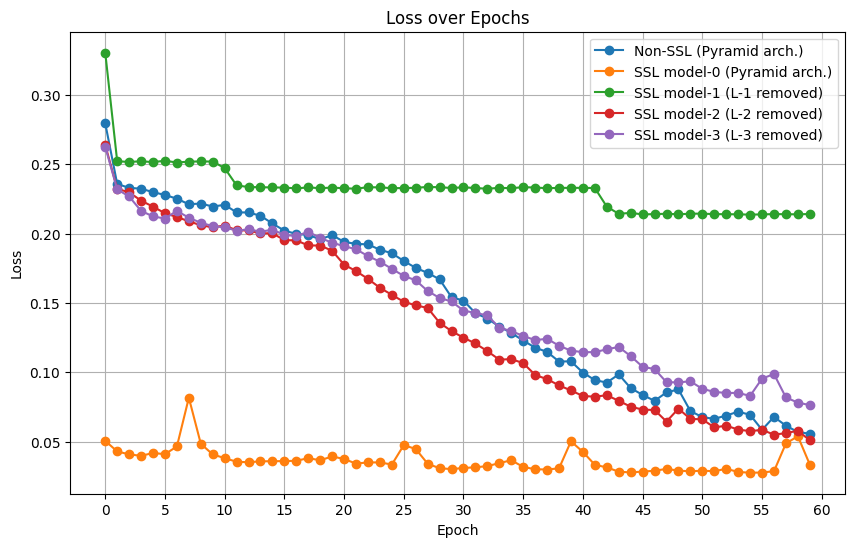

In [28]:
import matplotlib.pyplot as plt


# Adjusting epochs to match the desired x-axis range (1 to 50)
# adjusted_epochs = [i * 5 for i in range(1, 11)]  # 1, 5, 10, 15, ..., 50

epochs = range(len(loss_ssl_0))

# Plotting the data
plt.figure(figsize=(10, 6))

plt.plot(epochs, loss_non_ssl_0, marker='o', label='Non-SSL (Pyramid arch.)')
plt.plot(epochs, loss_ssl_0, marker='o', label='SSL model-0 (Pyramid arch.)')
plt.plot(epochs, loss_ssl_1, marker='o', label='SSL model-1 (L-1 removed)')
plt.plot(epochs, loss_ssl_2, marker='o', label='SSL model-2 (L-2 removed)')
plt.plot(epochs, loss_ssl_3, marker='o', label='SSL model-3 (L-3 removed)')



# Add other plots for SSL model-1, SSL model-2, SSL model-3...

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.xticks(range(0, 61, 5))  # Setting x-axis ticks to be from 0 to 50 with step of 5
plt.legend()
plt.grid(True)
plt.show()


In [21]:
#Skip 0 stats
print("pixel_accuracies_ssl",pixel_accuracies_ssl)
print("iou_scores_ssl",iou_scores_ssl)
print("average_loss_per_epoch_ssl",average_loss_per_epoch_ssl)


pixel_accuracies_ssl [0.9276256153219893, 0.9283826681891336, 0.9246603239808435, 0.9290685239045516, 0.9247307102790449, 0.9275689398197572, 0.926653928473705, 0.9238706158308262, 0.9267242937107758, 0.9253924299388857, 0.9284161869783579, 0.9276414532921411]
iou_scores_ssl [0.5046572350159039, 0.5050191911029567, 0.5055974319903953, 0.5035320047759303, 0.5047208523507434, 0.5047058115988434, 0.5047084313161383, 0.5064910980651799, 0.504917037134026, 0.5049179028666219, 0.5041097029552642, 0.5042953359741603]
average_loss_per_epoch_ssl [0.050464373967442355, 0.0428543417317579, 0.04072456531318241, 0.03967533880447755, 0.04172631903281791, 0.040871114220694116, 0.04642533389800559, 0.08159102515261518, 0.04842826546439545, 0.04065926108621264, 0.03802795109435753, 0.03538796714064284, 0.03504279219224805, 0.035714699812945935, 0.03577434964213378, 0.035889985505491495, 0.036100280532216436, 0.03799863355590509, 0.03646957375557045, 0.039238509541387606, 0.03738555303250587, 0.03406607

## Non SSL based Segmentation

In [35]:
iou_scores_nonssl, pixel_accuracies_nonssl = [], []
log_test_every = 5
# Assuming your SSL model is named 'ssl_model'
num_classes = 21  # Example: Number of classes in your segmentation dataset
non_ssl_model_0 = CompletionModel().to(device)
###########

for i in range(num_scales):
    if (i==skipped_scale):
      encoder = non_ssl_model_0.encoders[i]
      # Set encoder weights to 0
      for layer in encoder:
          if isinstance(layer, nn.Conv2d):
              layer.weight.data.fill_(0)
              layer.bias.data.fill_(0)
              # Freeze the weights of the encoder
      for param in encoder.parameters():
          param.requires_grad = False

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(non_ssl_model_0.parameters(), lr=learning_rate)

average_loss_per_epoch_non_ssl = []

# Train the model
for epoch in range(num_epochs):
    non_ssl_model_0.train()
    total_loss = 0
    num_batches = 0

    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = torch.as_tensor(np.array(targets), dtype=torch.long).squeeze(1).to(device)

        # Forward pass
        outputs = non_ssl_model_0(images)
        loss = criterion(outputs, targets.long())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1


        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Calculate the average loss for the epoch
    avg_loss = total_loss / num_batches
    average_loss_per_epoch_non_ssl.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")
    
    
    if (epoch+1) % log_test_every == 0:
        print("inside")
        avg_iou, avg_accuracy = evaluate_model(non_ssl_model_0, test_loader, device)
        iou_scores_nonssl.append(avg_iou)
        pixel_accuracies_nonssl.append(avg_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}] Test IoU: {avg_iou:.4f}, Pixel Accuracy: {avg_accuracy:.4f}")

    

Epoch [1/60], Step [100/366], Loss: 0.1820
Epoch [1/60], Step [200/366], Loss: 0.1507
Epoch [1/60], Step [300/366], Loss: 0.1917
Epoch [1/60] Average Loss: 0.2785
Epoch [2/60], Step [100/366], Loss: 0.1472
Epoch [2/60], Step [200/366], Loss: 0.1508
Epoch [2/60], Step [300/366], Loss: 0.2242
Epoch [2/60] Average Loss: 0.2494
Epoch [3/60], Step [100/366], Loss: 0.3253
Epoch [3/60], Step [200/366], Loss: 0.2390
Epoch [3/60], Step [300/366], Loss: 0.1932
Epoch [3/60] Average Loss: 0.2439
Epoch [4/60], Step [100/366], Loss: 0.2999
Epoch [4/60], Step [200/366], Loss: 0.2812
Epoch [4/60], Step [300/366], Loss: 0.1767
Epoch [4/60] Average Loss: 0.2437
Epoch [5/60], Step [100/366], Loss: 0.2466
Epoch [5/60], Step [200/366], Loss: 0.2753
Epoch [5/60], Step [300/366], Loss: 0.2273
Epoch [5/60] Average Loss: 0.2444
inside
Epoch [5/60] Test IoU: 0.4724, Pixel Accuracy: 0.9447
Epoch [6/60], Step [100/366], Loss: 0.1535
Epoch [6/60], Step [200/366], Loss: 0.1626
Epoch [6/60], Step [300/366], Loss: 0.

In [36]:
# skip 2
print("pixel_accuracies_ssl",pixel_accuracies_nonssl)
print("iou_scores_ssl",iou_scores_nonssl)
print("average_loss_per_epoch_ssl",average_loss_per_epoch_non_ssl)

pixel_accuracies_ssl [0.944718354977436, 0.944718354977436, 0.944718354977436, 0.944718354977436, 0.944718354977436, 0.944718354977436, 0.944718354977436, 0.944718354977436, 0.944718354977436, 0.944718354977436, 0.944718354977436, 0.944718354977436]
iou_scores_ssl [0.472359177488718, 0.472359177488718, 0.472359177488718, 0.472359177488718, 0.472359177488718, 0.472359177488718, 0.472359177488718, 0.472359177488718, 0.472359177488718, 0.472359177488718, 0.472359177488718, 0.472359177488718]
average_loss_per_epoch_ssl [0.27848540191523363, 0.2493591942707372, 0.2438824784438141, 0.24370918439222816, 0.24436222259057025, 0.24451385069984555, 0.24329123788518334, 0.24365951021105214, 0.242553531268581, 0.24319670039936492, 0.24274580048325936, 0.2432667217904427, 0.24247473466103195, 0.24256721820906213, 0.24251662801360824, 0.24312953068747548, 0.2431196657930567, 0.2427876952404533, 0.24285679363487847, 0.242943137334507, 0.24276769330185619, 0.2433542907034439, 0.24314375050732348, 0.242

In [22]:
loss_non_ssl_1 = [0.27848540191523363, 0.2493591942707372, 0.2438824784438141, 0.24370918439222816, 0.24436222259057025, 0.24451385069984555, 0.24329123788518334, 0.24365951021105214, 0.242553531268581, 0.24319670039936492, 0.24274580048325936, 0.2432667217904427, 0.24247473466103195, 0.24256721820906213, 0.24251662801360824, 0.24312953068747548, 0.2431196657930567, 0.2427876952404533, 0.24285679363487847, 0.242943137334507, 0.24276769330185619, 0.2433542907034439, 0.24314375050732348, 0.24292822974057146, 0.24250842871073167, 0.24271082212446166, 0.2430198153104287, 0.24209242985873927, 0.24250346206413592, 0.24291006675183446, 0.24252618867598597, 0.2421998904987437, 0.24143382605633448, 0.23471146251985936, 0.23281618659613562, 0.23308743748182809, 0.2336506546968645, 0.23259637160786514, 0.2327798958155301, 0.23334816415778925, 0.23280449382594373, 0.23280028007476708, 0.23261126120640932, 0.23308834997438344, 0.2327037463829817, 0.23317115395609797, 0.2327694069655215, 0.23240414015500924, 0.2330061316978736, 0.2327411252944196, 0.23276085661001544, 0.23303953657954768, 0.23267741238728898, 0.23290099905895406, 0.232709793180553, 0.2324968401566555, 0.232471871998955, 0.23261405891978024, 0.23251104466820674, 0.23275185596258913]
loss_non_ssl_2 =  [0.27839483662706904, 0.22796224196100495, 0.22691594725830957, 0.2271083213103925, 0.2284245173869237, 0.22556656104375106, 0.22677053741174316, 0.22617400295096016, 0.2252090829399114, 0.22576958604686248, 0.22404771819303596, 0.22449615671009313, 0.22440944774880436, 0.22465551200785924, 0.22366207520492742, 0.22350113930516555, 0.2237387576186266, 0.2231104265633828, 0.22350777392504645, 0.22325526228775092, 0.22326961344952792, 0.22349133309933658, 0.22362879637242014, 0.22314320803910007, 0.223318400360196, 0.22344489643971124, 0.22338549263490354, 0.2235884606593945, 0.2234754701821856, 0.22296517521468667, 0.2229378374466479, 0.2225924737832911, 0.22352654863494992, 0.22277924964011042, 0.22272089040263102, 0.22308060384350395, 0.22307443769414567, 0.22272818747276818, 0.22248181835061215, 0.22281674370983912, 0.22326032003092636, 0.22297044525869558, 0.22353197929393398, 0.2225666780818681, 0.2230087623732989, 0.2232136493294291, 0.22219614548191347, 0.22256801991921957, 0.22279608966222877, 0.22296021400335056, 0.22268111332029591, 0.22305518970952007, 0.22289929528786837, 0.2226463446973777, 0.22291192308556837, 0.22250048822311105, 0.22237230120786552, 0.2225609901539289, 0.2224041179148226, 0.22223735146753776]
loss_non_ssl_0 =  [0.27958389157887364, 0.23588496739747095, 0.23304634024210966, 0.23247255089748753, 0.22993478663469272, 0.22795450439055762, 0.22520986026346357, 0.2212188534560751, 0.22176001784824284, 0.2195562090867204, 0.22081148860558786, 0.21534424440049735, 0.21530331200996383, 0.2129061742599219, 0.20735006964678973, 0.20216218400441233, 0.1998492300998969, 0.19905513050696239, 0.19593423763748075, 0.19895964936236216, 0.19405291168416133, 0.19263336528601543, 0.19227296720599868, 0.18838852206295956, 0.18587828318644417, 0.180290408859976, 0.1753170306544975, 0.1716599194689201, 0.16706079122472983, 0.15408901605612593, 0.15169546780649756, 0.14265173652255145, 0.13872087794697024, 0.1329319071981425, 0.12837731039222797, 0.12287283868941128, 0.11773395221782186, 0.1146660205078581, 0.10773469509729922, 0.10787700611304064, 0.09975453902829866, 0.09429511590733554, 0.09255803717412259, 0.09843252107623171, 0.08855783131197502, 0.08362629994383601, 0.07935074606879813, 0.08546792614004, 0.0875869216092053, 0.07200723835597925, 0.06759943251238494, 0.0663660416745993, 0.06874051855500442, 0.07155164010578492, 0.06927212943511257, 0.05844500731127184, 0.06780293278009351, 0.06140129339927044, 0.0568741424457053, 0.055605705720601514]
loss_non_ssl_3 = [0.26398363974087874, 0.23233535653743587, 0.22984887893652656, 0.22381137938447337, 0.21948083693701062, 0.21474780128057538, 0.21200756842647095, 0.20894196118569114, 0.2060545446361349, 0.20458335362252641, 0.20587660260294957, 0.20240509865266051, 0.20234367691102575, 0.20019665181311103, 0.20031236077511244, 0.19533292495243537, 0.19514912415723332, 0.1914921475808477, 0.19144227182686002, 0.18765272269320618, 0.1776470132782811, 0.172993324208455, 0.16736570888204003, 0.16096173258386348, 0.15584290955887467, 0.1508429387960929, 0.14829339290577206, 0.14637495174271162, 0.13569719991723045, 0.1296636520126641, 0.12491697615490911, 0.12074654268436745, 0.1151804151471521, 0.10908300705416932, 0.10948175311984261, 0.10656422429560312, 0.09807022375975802, 0.09497626132937402, 0.0905457881732228, 0.08682451342217258, 0.08285716962822474, 0.08236430749256428, 0.08339643463125972, 0.07938827555931982, 0.07511056421192291, 0.07305956075141012, 0.07272645850447032, 0.06442961082513866, 0.07371002969540696, 0.06630571261862588, 0.06603976899422094, 0.060176739652381565, 0.061433827891294424, 0.05861775411160591, 0.05749801430301588, 0.05841964548911716, 0.05497460305955403, 0.05603501625623696, 0.05782135762274265, 0.05085929777330714]

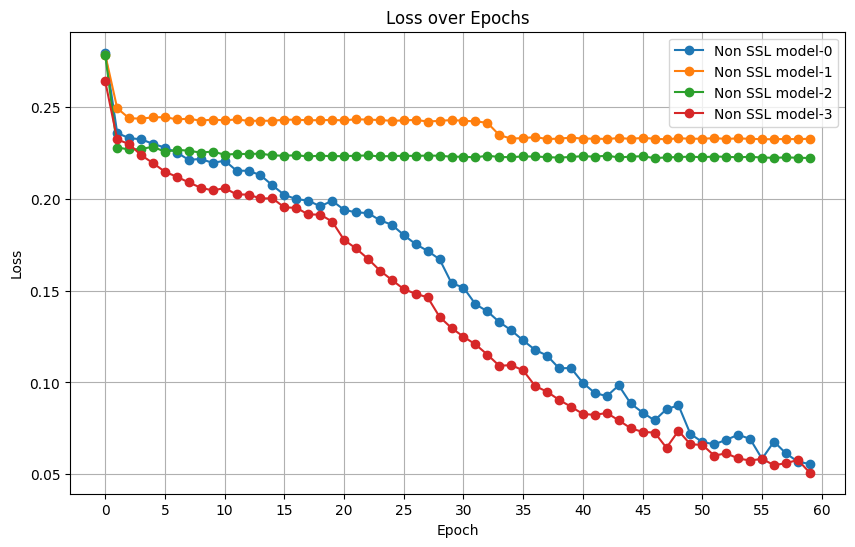

In [23]:
import matplotlib.pyplot as plt


# Adjusting epochs to match the desired x-axis range (1 to 50)
# adjusted_epochs = [i * 5 for i in range(1, 11)]  # 1, 5, 10, 15, ..., 50

epochs = range(len(loss_ssl_0))

# Plotting the data
plt.figure(figsize=(10, 6))

plt.plot(epochs, loss_non_ssl_0, marker='o', label='Non SSL model-0')
plt.plot(epochs, loss_non_ssl_1, marker='o', label='Non SSL model-1')
plt.plot(epochs, loss_non_ssl_2, marker='o', label='Non SSL model-2')
plt.plot(epochs, loss_non_ssl_3, marker='o', label='Non SSL model-3')


# Add other plots for SSL model-1, SSL model-2, SSL model-3...

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.xticks(range(0, 61, 5))  # Setting x-axis ticks to be from 0 to 50 with step of 5
plt.legend()
plt.grid(True)
plt.show()


In [43]:
iou_scores_nonssl, pixel_accuracies_nonssl = [], []

# Assuming your SSL model is named 'ssl_model'
num_classes = 21  # Example: Number of classes in your segmentation dataset
non_ssl_model_0 = CompletionModel().to(device)
###########

for i in range(num_scales):
    if (i==skipped_scale):
      encoder = non_ssl_model_0.encoders[i]
      # Set encoder weights to 0
      for layer in encoder:
          if isinstance(layer, nn.Conv2d):
              layer.weight.data.fill_(0)
              layer.bias.data.fill_(0)
              # Freeze the weights of the encoder
      for param in encoder.parameters():
          param.requires_grad = False

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(non_ssl_model_0.parameters(), lr=learning_rate)

average_loss_per_epoch_non_ssl = []

# Train the model
for epoch in range(num_epochs):
    non_ssl_model_0.train()
    total_loss = 0
    num_batches = 0

    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = torch.as_tensor(np.array(targets), dtype=torch.long).squeeze(1).to(device)

        # Forward pass
        outputs = non_ssl_model_0(images)
        loss = criterion(outputs, targets.long())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1


        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Calculate the average loss for the epoch
    avg_loss = total_loss / num_batches
    average_loss_per_epoch_non_ssl.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")
    
    
    if (epoch+1) % log_test_every == 0:
        print("inside")
        avg_iou, avg_accuracy = evaluate_model(non_ssl_model_0, test_loader, device)
        iou_scores_nonssl.append(avg_iou)
        pixel_accuracies_nonssl.append(avg_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}] Test IoU: {avg_iou:.4f}, Pixel Accuracy: {avg_accuracy:.4f}")

    

Epoch [1/60], Step [100/366], Loss: 0.2907
Epoch [1/60], Step [200/366], Loss: 0.3527
Epoch [1/60], Step [300/366], Loss: 0.2263
Epoch [1/60] Average Loss: 0.2640
Epoch [2/60], Step [100/366], Loss: 0.2360
Epoch [2/60], Step [200/366], Loss: 0.7289
Epoch [2/60], Step [300/366], Loss: 0.0928
Epoch [2/60] Average Loss: 0.2323
Epoch [3/60], Step [100/366], Loss: 0.2353
Epoch [3/60], Step [200/366], Loss: 0.2332
Epoch [3/60], Step [300/366], Loss: 0.3631
Epoch [3/60] Average Loss: 0.2298
Epoch [4/60], Step [100/366], Loss: 0.2005
Epoch [4/60], Step [200/366], Loss: 0.1380
Epoch [4/60], Step [300/366], Loss: 0.2271
Epoch [4/60] Average Loss: 0.2238
Epoch [5/60], Step [100/366], Loss: 0.2299
Epoch [5/60], Step [200/366], Loss: 0.1243
Epoch [5/60], Step [300/366], Loss: 0.3846
Epoch [5/60] Average Loss: 0.2195
inside
Epoch [5/60] Test IoU: 0.4724, Pixel Accuracy: 0.9447
Epoch [6/60], Step [100/366], Loss: 0.1984
Epoch [6/60], Step [200/366], Loss: 0.6879
Epoch [6/60], Step [300/366], Loss: 0.

In [44]:
print("pixel_accuracies_ssl",pixel_accuracies_nonssl)
print("iou_scores_ssl",iou_scores_nonssl)
print("average_loss_per_epoch_ssl",average_loss_per_epoch_non_ssl)

pixel_accuracies_ssl [0.944718354977436, 0.9447183339163054, 0.944720418968227, 0.9442832004291752, 0.9409604806419567, 0.9365457201760913, 0.938068555748981, 0.9247367653540696, 0.9325329429779158, 0.926189256751019, 0.9277849954272074, 0.9296123012334746]
iou_scores_ssl [0.472359177488718, 0.4723633385283394, 0.4743280362111344, 0.48632322267963896, 0.48491896958986275, 0.4957680211405677, 0.4955608545737417, 0.5041675786542961, 0.5017362144900873, 0.5052687218647057, 0.5037805189760255, 0.5021939404624515]
average_loss_per_epoch_ssl [0.26398363974087874, 0.23233535653743587, 0.22984887893652656, 0.22381137938447337, 0.21948083693701062, 0.21474780128057538, 0.21200756842647095, 0.20894196118569114, 0.2060545446361349, 0.20458335362252641, 0.20587660260294957, 0.20240509865266051, 0.20234367691102575, 0.20019665181311103, 0.20031236077511244, 0.19533292495243537, 0.19514912415723332, 0.1914921475808477, 0.19144227182686002, 0.18765272269320618, 0.1776470132782811, 0.172993324208455, 

## Segmentation without SSL Based model

In [11]:
# Data loader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)


# Assuming your SSL model is named 'ssl_model'
num_classes = 21  # Example: Number of classes in your segmentation dataset
non_ssl_model = CompletionModel().to(device)
###########

for i in range(num_scales):
    if (i==skipped_scale):
      encoder = non_ssl_model.encoders[i]
      # Set encoder weights to 0
      for layer in encoder:
          if isinstance(layer, nn.Conv2d):
              layer.weight.data.fill_(0)
              layer.bias.data.fill_(0)
              # Freeze the weights of the encoder
      for param in encoder.parameters():
          param.requires_grad = False

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(non_ssl_model.parameters(), lr=learning_rate)

average_loss_per_epoch_non_ssl = []

# Train the model
for epoch in range(num_epochs):
    non_ssl_model.train()
    total_loss = 0
    num_batches = 0

    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = torch.as_tensor(np.array(targets), dtype=torch.long).squeeze(1).to(device)

        # Forward pass
        outputs = non_ssl_model(images)
        loss = criterion(outputs, targets.long())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1


        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Calculate the average loss for the epoch
    avg_loss = total_loss / num_batches
    average_loss_per_epoch_non_ssl.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")

total_accuracy = 0

# Test the model
non_ssl_model.eval()
with torch.no_grad():
    total_iou = 0
    for images, targets in test_loader:
        images = images.to(device)
        targets = torch.as_tensor(np.array(targets), dtype=torch.long).squeeze(1).to(device)
        outputs = non_ssl_model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu().numpy()

        for i in range(len(targets)):
          total_iou += jaccard_score(targets[i].cpu().flatten(), predicted[i].flatten(), average='macro')

          # Calculate accuracy for each image and accumulate
          total_accuracy += accuracy_score(targets[i].cpu().flatten(), predicted[i].flatten())


average_accuracy = total_accuracy / len(test_loader.dataset)
print(f"Average Pixel Accuracy on the test set: {average_accuracy:.4f}")

average_iou = total_iou / len(test_loader.dataset)
print(f"Average IoU on the test set: {average_iou:.4f}")


Epoch [1/60], Step [100/366], Loss: 0.2532
Epoch [1/60], Step [200/366], Loss: 0.2046
Epoch [1/60], Step [300/366], Loss: 0.2157
Epoch [1/60] Average Loss: 0.2761
Epoch [2/60], Step [100/366], Loss: 0.1646
Epoch [2/60], Step [200/366], Loss: 0.4526
Epoch [2/60], Step [300/366], Loss: 0.1803
Epoch [2/60] Average Loss: 0.2219
Epoch [3/60], Step [100/366], Loss: 0.1215
Epoch [3/60], Step [200/366], Loss: 0.2081
Epoch [3/60], Step [300/366], Loss: 0.1872
Epoch [3/60] Average Loss: 0.2162
Epoch [4/60], Step [100/366], Loss: 0.1512
Epoch [4/60], Step [200/366], Loss: 0.2376
Epoch [4/60], Step [300/366], Loss: 0.4998
Epoch [4/60] Average Loss: 0.2127
Epoch [5/60], Step [100/366], Loss: 0.5168
Epoch [5/60], Step [200/366], Loss: 0.1852
Epoch [5/60], Step [300/366], Loss: 0.2020
Epoch [5/60] Average Loss: 0.2119
Epoch [6/60], Step [100/366], Loss: 0.1796
Epoch [6/60], Step [200/366], Loss: 0.1673
Epoch [6/60], Step [300/366], Loss: 0.1200
Epoch [6/60] Average Loss: 0.2114
Epoch [7/60], Step [10

# Comparison b/w SSL and non-SSL for segmentation

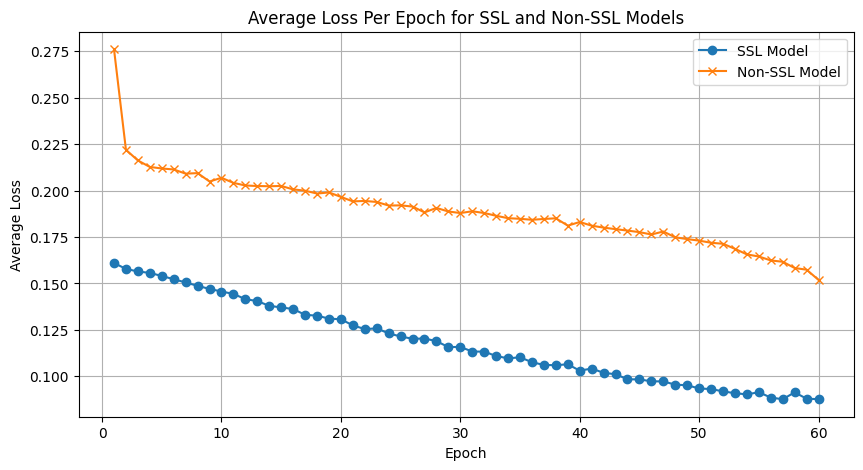

In [12]:
# step 0

import matplotlib.pyplot as plt

# Number of epochs (assuming both lists are of the same length)
epochs = list(range(1, len(average_loss_per_epoch_ssl) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, average_loss_per_epoch_ssl, label='SSL Model', marker='o')
plt.plot(epochs, average_loss_per_epoch_non_ssl, label='Non-SSL Model', marker='x')
plt.title('Average Loss Per Epoch for SSL and Non-SSL Models')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)

#  Old Code

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50
from sklearn.metrics import jaccard_score
import numpy as np
from sklearn.metrics import accuracy_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 30
batch_size = 4
learning_rate = 0.0005

In [20]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# VOC2012 Segmentation dataset
train_dataset = VOCSegmentation(root='./data',
                                year='2012',
                                image_set='train',
                                download=True,
                                transform=transform,
                                target_transform=transform)

test_dataset = VOCSegmentation(root='./data',
                               year='2012',
                               image_set='val',
                               download=True,
                               transform=transform,
                               target_transform=transform)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [55]:
model = CompletionModel().to(device)
model.load_state_dict(torch.load('ssl_model-50.pth'))

<All keys matched successfully>

In [54]:
skipped_scale = 1

In [23]:
# Data loader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [56]:
for i in range(num_scales):
    if (i==skipped_scale):
      encoder = model.encoders[i]
      # Set encoder weights to 0
      for layer in encoder:
          if isinstance(layer, nn.Conv2d):
              layer.weight.data.fill_(1)
              layer.bias.data.fill_(0)
              # Freeze the weights of the encoder
      for param in encoder.parameters():
          param.requires_grad = False

num_classes = 21  # Example: Number of classes in your segmentation dataset
# model = SegmentationModel(model.encoders[1], 3).to(device)
###########

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

average_loss_per_epoch_ssl = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_batches = 0

    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = torch.as_tensor(np.array(targets), dtype=torch.long).squeeze(1).to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, targets.long())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1


        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / num_batches
    average_loss_per_epoch_ssl.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")


# Test the model
model.eval()
total_accuracy = 0

with torch.no_grad():
    total_iou = 0
    for images, targets in test_loader:
        images = images.to(device)
        targets = torch.as_tensor(np.array(targets), dtype=torch.long).squeeze(1).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu().numpy()

        for i in range(len(targets)):
            total_iou += jaccard_score(targets[i].flatten().cpu(), predicted[i].flatten(), average='macro')

            # Calculate accuracy for each image and accumulate
            total_accuracy += accuracy_score(targets[i].cpu().flatten(), predicted[i].flatten())


average_accuracy = total_accuracy / len(test_loader.dataset)
print(f"Average Pixel Accuracy on the test set: {average_accuracy:.4f}")


average_iou = total_iou / len(test_loader.dataset)
print(f"Average IoU on the test set: {average_iou:.4f}")


ssl_average_iou = average_iou
ssl_average_accuracy = average_accuracy

Epoch [1/30], Step [100/366], Loss: 0.1745
Epoch [1/30], Step [200/366], Loss: 0.3551
Epoch [1/30], Step [300/366], Loss: 0.1325
Epoch [1/30] Average Loss: 0.2634
Epoch [2/30], Step [100/366], Loss: 0.2306
Epoch [2/30], Step [200/366], Loss: 0.2940
Epoch [2/30], Step [300/366], Loss: 0.2028
Epoch [2/30] Average Loss: 0.2062
Epoch [3/30], Step [100/366], Loss: 0.1559
Epoch [3/30], Step [200/366], Loss: 0.2264
Epoch [3/30], Step [300/366], Loss: 0.3322
Epoch [3/30] Average Loss: 0.2014
Epoch [4/30], Step [100/366], Loss: 0.3094
Epoch [4/30], Step [200/366], Loss: 0.1951
Epoch [4/30], Step [300/366], Loss: 0.2392
Epoch [4/30] Average Loss: 0.2002
Epoch [5/30], Step [100/366], Loss: 0.1255
Epoch [5/30], Step [200/366], Loss: 0.1478
Epoch [5/30], Step [300/366], Loss: 0.2273
Epoch [5/30] Average Loss: 0.1983
Epoch [6/30], Step [100/366], Loss: 0.1415
Epoch [6/30], Step [200/366], Loss: 0.1675
Epoch [6/30], Step [300/366], Loss: 0.1101
Epoch [6/30] Average Loss: 0.1978
Epoch [7/30], Step [10

In [57]:
# Assuming your SSL model is named 'ssl_model'
num_classes = 21  # Example: Number of classes in your segmentation dataset
non_ssl_model_2 = CompletionModel().to(device)
###########

for i in range(num_scales):
    if (i==skipped_scale):
      encoder = non_ssl_model_2.encoders[i]
      # Set encoder weights to 0
      for layer in encoder:
          if isinstance(layer, nn.Conv2d):
              layer.weight.data.fill_(1)
              layer.bias.data.fill_(0)
              # Freeze the weights of the encoder
      for param in encoder.parameters():
          param.requires_grad = False

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(non_ssl_model_2.parameters(), lr=learning_rate)

average_loss_per_epoch_non_ssl = []

# Train the model
for epoch in range(num_epochs):
    non_ssl_model_2.train()
    total_loss = 0
    num_batches = 0

    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = torch.as_tensor(np.array(targets), dtype=torch.long).squeeze(1).to(device)

        # Forward pass
        outputs = non_ssl_model_2(images)
        loss = criterion(outputs, targets.long())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1


        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Calculate the average loss for the epoch
    avg_loss = total_loss / num_batches
    average_loss_per_epoch_non_ssl.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")

total_accuracy = 0

# Test the model
non_ssl_model_2.eval()
with torch.no_grad():
    total_iou = 0
    for images, targets in test_loader:
        images = images.to(device)
        targets = torch.as_tensor(np.array(targets), dtype=torch.long).squeeze(1).to(device)
        outputs = non_ssl_model_2(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu().numpy()

        for i in range(len(targets)):
          total_iou += jaccard_score(targets[i].cpu().flatten(), predicted[i].flatten(), average='macro')

          # Calculate accuracy for each image and accumulate
          total_accuracy += accuracy_score(targets[i].cpu().flatten(), predicted[i].flatten())


average_accuracy = total_accuracy / len(test_loader.dataset)
print(f"Average Pixel Accuracy on the test set: {average_accuracy:.4f}")

average_iou = total_iou / len(test_loader.dataset)
print(f"Average IoU on the test set: {average_iou:.4f}")


nonssl_average_iou = average_iou
nonssl_average_accuracy = average_accuracy

Epoch [1/30], Step [100/366], Loss: 0.2168
Epoch [1/30], Step [200/366], Loss: 0.2170
Epoch [1/30], Step [300/366], Loss: 0.2268
Epoch [1/30] Average Loss: 0.2594
Epoch [2/30], Step [100/366], Loss: 0.1600
Epoch [2/30], Step [200/366], Loss: 0.2017
Epoch [2/30], Step [300/366], Loss: 0.2346
Epoch [2/30] Average Loss: 0.2270
Epoch [3/30], Step [100/366], Loss: 0.4040
Epoch [3/30], Step [200/366], Loss: 0.1451
Epoch [3/30], Step [300/366], Loss: 0.1832
Epoch [3/30] Average Loss: 0.2216
Epoch [4/30], Step [100/366], Loss: 0.1676
Epoch [4/30], Step [200/366], Loss: 0.2658
Epoch [4/30], Step [300/366], Loss: 0.1674
Epoch [4/30] Average Loss: 0.2169
Epoch [5/30], Step [100/366], Loss: 0.1536
Epoch [5/30], Step [200/366], Loss: 0.7635
Epoch [5/30], Step [300/366], Loss: 0.4176
Epoch [5/30] Average Loss: 0.2182
Epoch [6/30], Step [100/366], Loss: 0.1191
Epoch [6/30], Step [200/366], Loss: 0.1819
Epoch [6/30], Step [300/366], Loss: 0.1542
Epoch [6/30] Average Loss: 0.2165
Epoch [7/30], Step [10

## Weight=1, epochs=30  , skip=2  - B

In [58]:
print(f"For SSL Average Pixel Accuracy on the test set: {ssl_average_accuracy:.4f} and Average IoU on the test set: {ssl_average_iou:.4f}")
print(f"For non-SSL Average Pixel Accuracy on the test set: {nonssl_average_accuracy:.4f} and Average IoU on the test set: {nonssl_average_iou:.4f}")

For SSL Average Pixel Accuracy on the test set: 0.9404 and Average IoU on the test set: 0.4931
For non-SSL Average Pixel Accuracy on the test set: 0.9446 and Average IoU on the test set: 0.4822


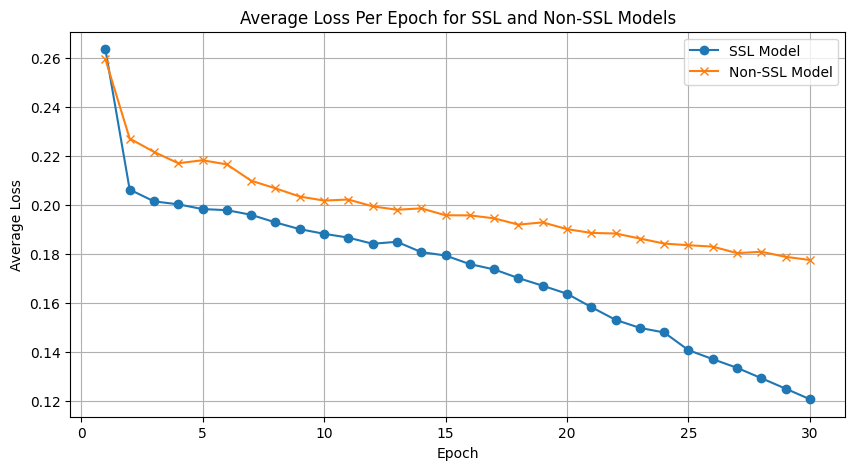

In [59]:
# step 2

import matplotlib.pyplot as plt

# Number of epochs (assuming both lists are of the same length)
epochs = list(range(1, len(average_loss_per_epoch_ssl) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, average_loss_per_epoch_ssl, label='SSL Model', marker='o')
plt.plot(epochs, average_loss_per_epoch_non_ssl, label='Non-SSL Model', marker='x')
plt.title('Average Loss Per Epoch for SSL and Non-SSL Models')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)

## Weight=1, epochs=30  , skip=3  - B

In [52]:
print(f"For SSL Average Pixel Accuracy on the test set: {ssl_average_accuracy:.4f} and Average IoU on the test set: {ssl_average_iou:.4f}")
print(f"For non-SSL Average Pixel Accuracy on the test set: {nonssl_average_accuracy:.4f} and Average IoU on the test set: {nonssl_average_iou:.4f}")

For SSL Average Pixel Accuracy on the test set: 0.9397 and Average IoU on the test set: 0.4968
For non-SSL Average Pixel Accuracy on the test set: 0.9428 and Average IoU on the test set: 0.4871


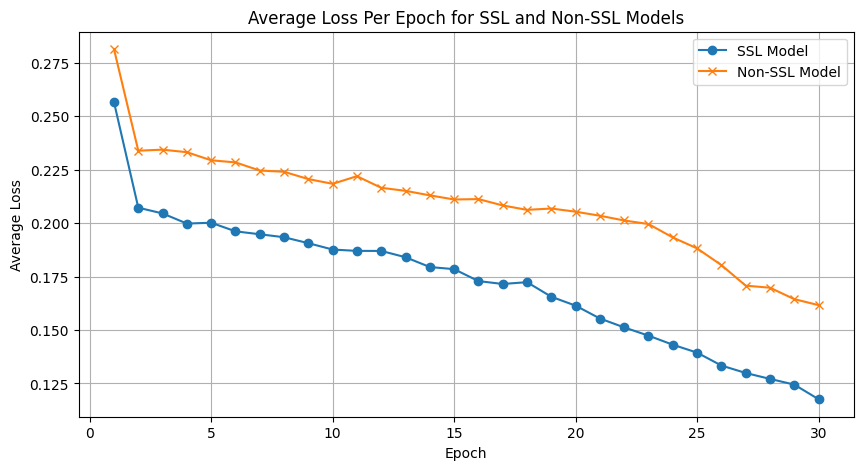

In [53]:
# step 2

import matplotlib.pyplot as plt

# Number of epochs (assuming both lists are of the same length)
epochs = list(range(1, len(average_loss_per_epoch_ssl) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, average_loss_per_epoch_ssl, label='SSL Model', marker='o')
plt.plot(epochs, average_loss_per_epoch_non_ssl, label='Non-SSL Model', marker='x')
plt.title('Average Loss Per Epoch for SSL and Non-SSL Models')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)

## Weight=1, epochs=30  , skip=3

In [40]:
print(f"For SSL Average Pixel Accuracy on the test set: {ssl_average_accuracy:.4f} and Average IoU on the test set: {ssl_average_iou:.4f}")
print(f"For non-SSL Average Pixel Accuracy on the test set: {nonssl_average_accuracy:.4f} and Average IoU on the test set: {nonssl_average_iou:.4f}")

For SSL Average Pixel Accuracy on the test set: 0.9419 and Average IoU on the test set: 0.4906
For non-SSL Average Pixel Accuracy on the test set: 0.9443 and Average IoU on the test set: 0.4827


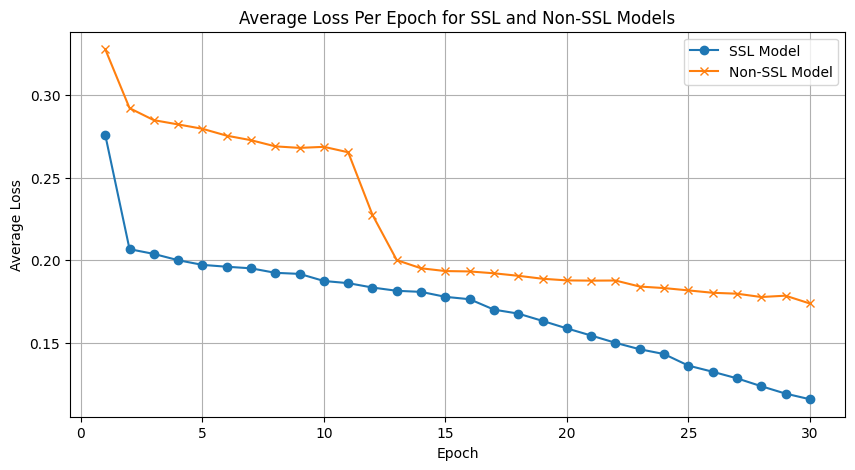

In [41]:
# step 2

import matplotlib.pyplot as plt

# Number of epochs (assuming both lists are of the same length)
epochs = list(range(1, len(average_loss_per_epoch_ssl) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, average_loss_per_epoch_ssl, label='SSL Model', marker='o')
plt.plot(epochs, average_loss_per_epoch_non_ssl, label='Non-SSL Model', marker='x')
plt.title('Average Loss Per Epoch for SSL and Non-SSL Models')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)

## Weight=1, epochs=30  , skip=2

In [34]:
print(f"For SSL Average Pixel Accuracy on the test set: {ssl_average_accuracy:.4f} and Average IoU on the test set: {ssl_average_iou:.4f}")
print(f"For non-SSL Average Pixel Accuracy on the test set: {nonssl_average_accuracy:.4f} and Average IoU on the test set: {nonssl_average_iou:.4f}")

For SSL Average Pixel Accuracy on the test set: 0.9447 and Average IoU on the test set: 0.4724
For non-SSL Average Pixel Accuracy on the test set: 0.9447 and Average IoU on the test set: 0.4799


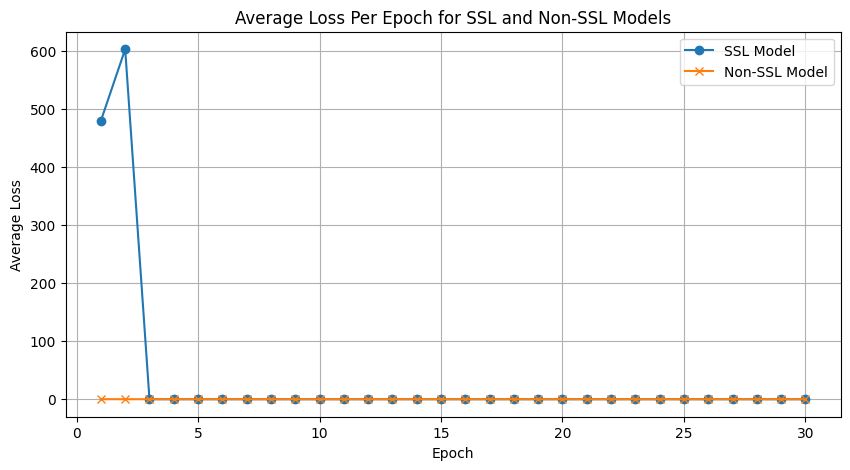

In [35]:
# step 2

import matplotlib.pyplot as plt

# Number of epochs (assuming both lists are of the same length)
epochs = list(range(1, len(average_loss_per_epoch_ssl) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, average_loss_per_epoch_ssl, label='SSL Model', marker='o')
plt.plot(epochs, average_loss_per_epoch_non_ssl, label='Non-SSL Model', marker='x')
plt.title('Average Loss Per Epoch for SSL and Non-SSL Models')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)

## Weight=1, epochs=30  , skip=1

In [46]:
print(f"For SSL Average Pixel Accuracy on the test set: {ssl_average_accuracy:.4f} and Average IoU on the test set: {ssl_average_iou:.4f}")
print(f"For non-SSL Average Pixel Accuracy on the test set: {nonssl_average_accuracy:.4f} and Average IoU on the test set: {nonssl_average_iou:.4f}")

For SSL Average Pixel Accuracy on the test set: 0.9395 and Average IoU on the test set: 0.4982
For non-SSL Average Pixel Accuracy on the test set: 0.9441 and Average IoU on the test set: 0.4911


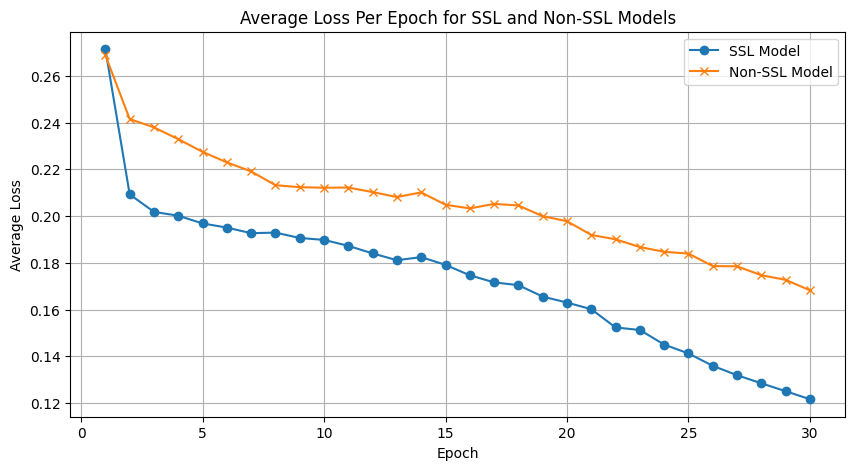

In [47]:
# step 2

import matplotlib.pyplot as plt

# Number of epochs (assuming both lists are of the same length)
epochs = list(range(1, len(average_loss_per_epoch_ssl) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, average_loss_per_epoch_ssl, label='SSL Model', marker='o')
plt.plot(epochs, average_loss_per_epoch_non_ssl, label='Non-SSL Model', marker='x')
plt.title('Average Loss Per Epoch for SSL and Non-SSL Models')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)

## Weight=1, epochs=30  , skip=0

In [26]:
print(f"For SSL Average Pixel Accuracy on the test set: {ssl_average_accuracy:.4f} and Average IoU on the test set: {ssl_average_iou:.4f}")
print(f"For non-SSL Average Pixel Accuracy on the test set: {nonssl_average_accuracy:.4f} and Average IoU on the test set: {nonssl_average_iou:.4f}")

For SSL Average Pixel Accuracy on the test set: 0.9409 and Average IoU on the test set: 0.4901
For non-SSL Average Pixel Accuracy on the test set: 0.9440 and Average IoU on the test set: 0.4830


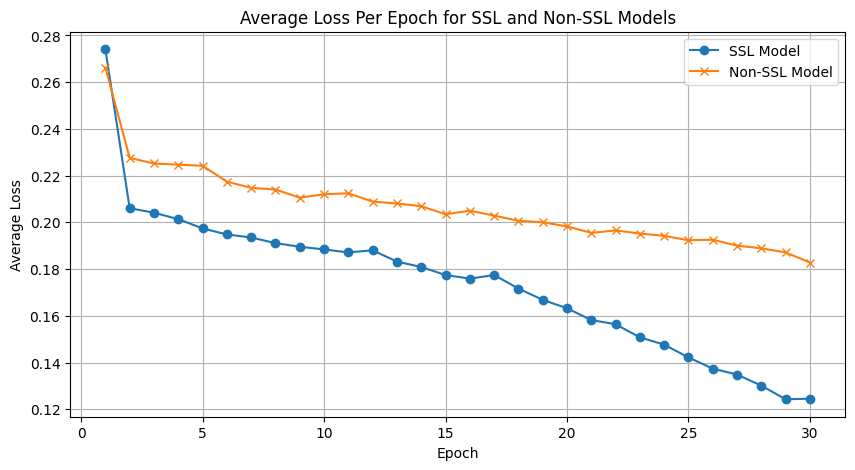

In [27]:
# step 2

import matplotlib.pyplot as plt

# Number of epochs (assuming both lists are of the same length)
epochs = list(range(1, len(average_loss_per_epoch_ssl) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, average_loss_per_epoch_ssl, label='SSL Model', marker='o')
plt.plot(epochs, average_loss_per_epoch_non_ssl, label='Non-SSL Model', marker='x')
plt.title('Average Loss Per Epoch for SSL and Non-SSL Models')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)

### skip = 3 or layer removed = 2    , epoch-100

In [14]:
print(f"For SSL Average Pixel Accuracy on the test set: {ssl_average_accuracy:.4f} and Average IoU on the test set: {ssl_average_iou:.4f}")
print(f"For non-SSL Average Pixel Accuracy on the test set: {nonssl_average_accuracy:.4f} and Average IoU on the test set: {nonssl_average_iou:.4f}")

For SSL Average Pixel Accuracy on the test set: 0.9268 and Average IoU on the test set: 0.5072
For non-SSL Average Pixel Accuracy on the test set: 0.9257 and Average IoU on the test set: 0.5065


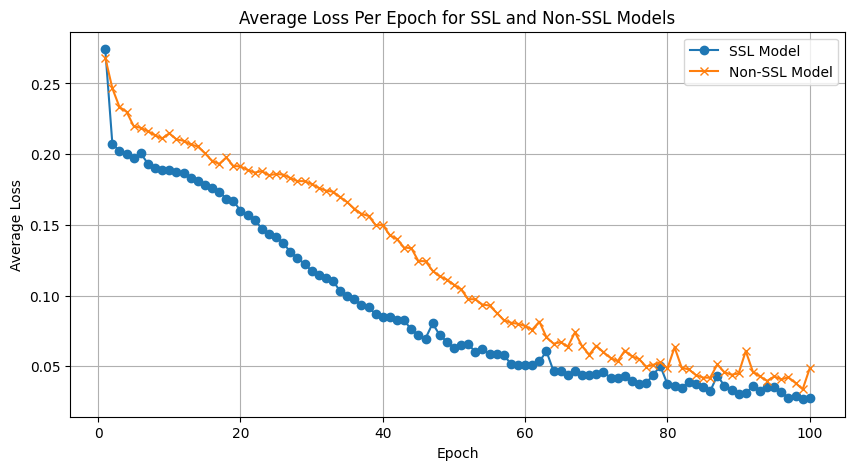

In [15]:
# step 2

import matplotlib.pyplot as plt

# Number of epochs (assuming both lists are of the same length)
epochs = list(range(1, len(average_loss_per_epoch_ssl) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, average_loss_per_epoch_ssl, label='SSL Model', marker='o')
plt.plot(epochs, average_loss_per_epoch_non_ssl, label='Non-SSL Model', marker='x')
plt.title('Average Loss Per Epoch for SSL and Non-SSL Models')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)

### skip = 3 or layer removed = 2

In [5]:
print(f"For SSL Average Pixel Accuracy on the test set: {ssl_average_accuracy:.4f} and Average IoU on the test set: {ssl_average_iou:.4f}")
print(f"For non-SSL Average Pixel Accuracy on the test set: {nonssl_average_accuracy:.4f} and Average IoU on the test set: {nonssl_average_iou:.4f}")

For SSL Average Pixel Accuracy on the test set: 0.9299 and Average IoU on the test set: 0.5069
For non-SSL Average Pixel Accuracy on the test set: 0.9311 and Average IoU on the test set: 0.5110


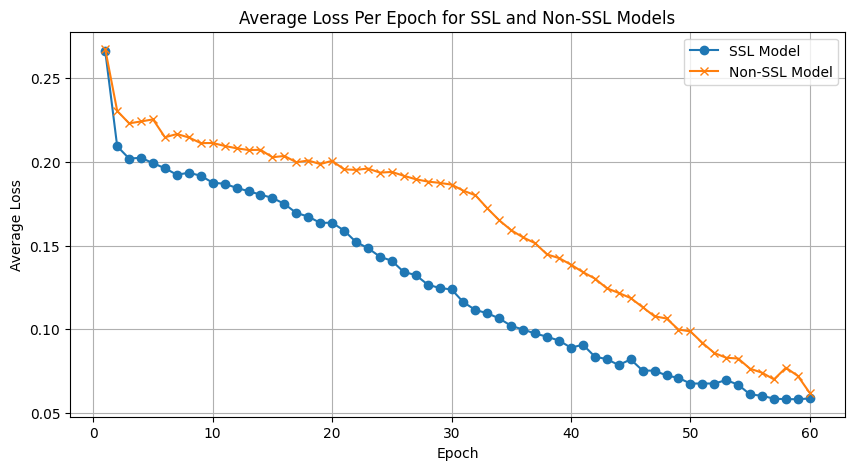

In [6]:
# step 2

import matplotlib.pyplot as plt

# Number of epochs (assuming both lists are of the same length)
epochs = list(range(1, len(average_loss_per_epoch_ssl) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, average_loss_per_epoch_ssl, label='SSL Model', marker='o')
plt.plot(epochs, average_loss_per_epoch_non_ssl, label='Non-SSL Model', marker='x')
plt.title('Average Loss Per Epoch for SSL and Non-SSL Models')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)

### skip = 2 or layer removed = 1

In [40]:
print(f"For SSL Average Pixel Accuracy on the test set: {ssl_average_accuracy:.4f} and Average IoU on the test set: {ssl_average_iou:.4f}")
print(f"For non-SSL Average Pixel Accuracy on the test set: {nonssl_average_accuracy:.4f} and Average IoU on the test set: {nonssl_average_iou:.4f}")

For SSL Average Pixel Accuracy on the test set: 0.9303 and Average IoU on the test set: 0.5061
For non-SSL Average Pixel Accuracy on the test set: 0.9333 and Average IoU on the test set: 0.5067


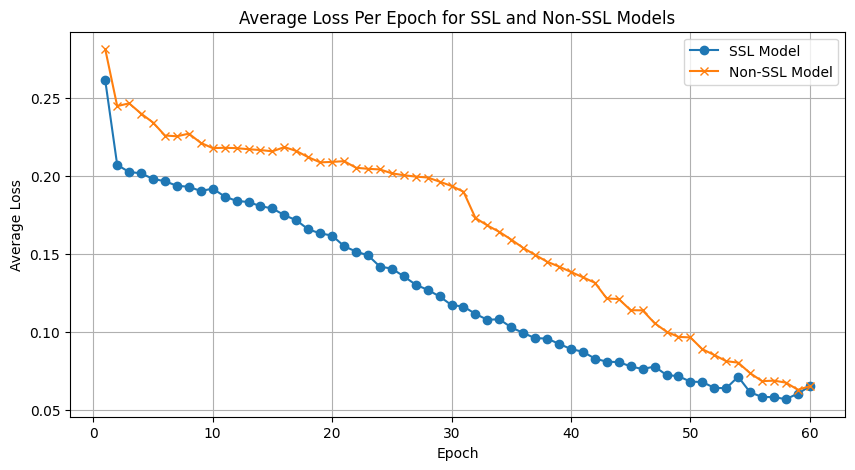

In [41]:
# step 1

import matplotlib.pyplot as plt

# Number of epochs (assuming both lists are of the same length)
epochs = list(range(1, len(average_loss_per_epoch_ssl) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, average_loss_per_epoch_ssl, label='SSL Model', marker='o')
plt.plot(epochs, average_loss_per_epoch_non_ssl, label='Non-SSL Model', marker='x')
plt.title('Average Loss Per Epoch for SSL and Non-SSL Models')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)

### skip = 1 or layer removed = 0

In [34]:
print(f"For SSL Average Pixel Accuracy on the test set: {ssl_average_accuracy:.4f} and Average IoU on the test set: {ssl_average_iou:.4f}")
print(f"For non-SSL Average Pixel Accuracy on the test set: {nonssl_average_accuracy:.4f} and Average IoU on the test set: {nonssl_average_iou:.4f}")

For SSL Average Pixel Accuracy on the test set: 0.9447 and Average IoU on the test set: 0.4724
For non-SSL Average Pixel Accuracy on the test set: 0.9447 and Average IoU on the test set: 0.4724


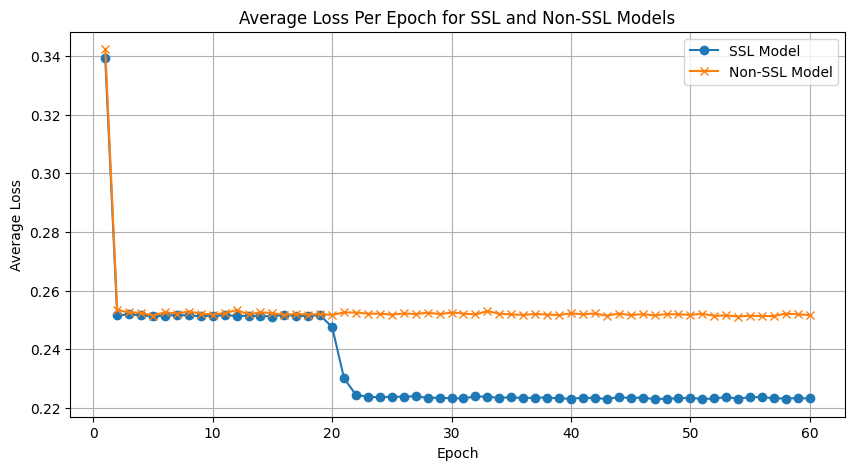

In [35]:
# step 1

import matplotlib.pyplot as plt

# Number of epochs (assuming both lists are of the same length)
epochs = list(range(1, len(average_loss_per_epoch_ssl) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, average_loss_per_epoch_ssl, label='SSL Model', marker='o')
plt.plot(epochs, average_loss_per_epoch_non_ssl, label='Non-SSL Model', marker='x')
plt.title('Average Loss Per Epoch for SSL and Non-SSL Models')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)

### skip = 0 or layer removed = -1 

In [29]:
print(f"For SSL Average Pixel Accuracy on the test set: {ssl_average_accuracy:.4f} and Average IoU on the test set: {ssl_average_iou:.4f}")
print(f"For non-SSL Average Pixel Accuracy on the test set: {nonssl_average_accuracy:.4f} and Average IoU on the test set: {nonssl_average_iou:.4f}")

For SSL Average Pixel Accuracy on the test set: 0.9312 and Average IoU on the test set: 0.5035
For non-SSL Average Pixel Accuracy on the test set: 0.9287 and Average IoU on the test set: 0.5074


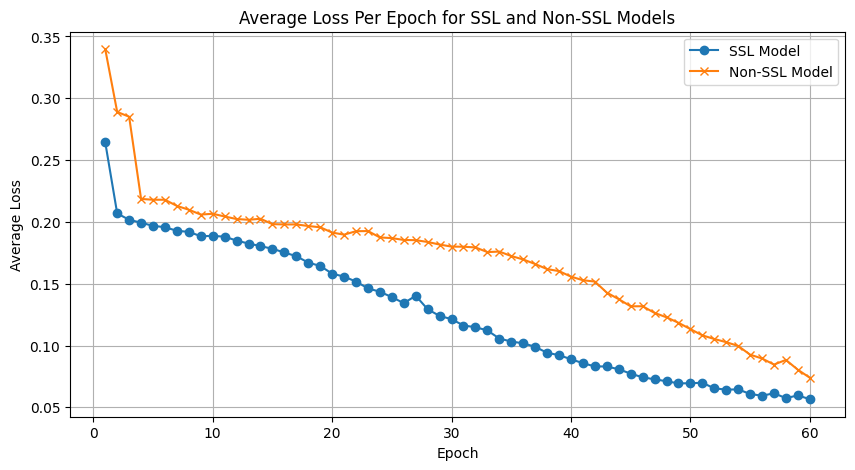

In [26]:
# step 0

import matplotlib.pyplot as plt

# Number of epochs (assuming both lists are of the same length)
epochs = list(range(1, len(average_loss_per_epoch_ssl) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, average_loss_per_epoch_ssl, label='SSL Model', marker='o')
plt.plot(epochs, average_loss_per_epoch_non_ssl, label='Non-SSL Model', marker='x')
plt.title('Average Loss Per Epoch for SSL and Non-SSL Models')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)